In [1]:
import geopandas
from ipyleaflet import Map, Marker, Popup, basemaps, GeoData, MarkerCluster, FullScreenControl, LayersControl, basemap_to_tiles

import copy

%matplotlib inline
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.dates import DateFormatter

# NWIS API library
import dataretrieval.nwis as nwis

In [2]:
# Filesystem
import sys
sys.path.append("../../")

Parameters:

Temperature, air, °C : 00010

Nitrate plus nitrite, water, in situ, milligrams per liter as nitrogen: 99133

Dissolved oxygen, water, unfiltered, milligrams per liter: 00300

Discharge, cubic feed per second : 00060

In Washington State:

Multiple sites have temperature, DO data, and discharge
One site has nitrite/nitrate data (12473503)
No phosphate/phosphorus data

In [35]:
final_parameters = ["00095","00060","00010","99133","00300"]
startDate = "2019-04-20"
endDate = "2021-07-19"

In [39]:
# ringold_iv = nwis.get_record(sites="12473503",service="iv",parameterCd=final_parameters,start=startDate,end=endDate)
# ringold_dv = nwis.get_record(sites="12473503",service="dv",parameterCd=final_parameters,start=startDate,end=endDate)

%store -r ringold_iv
%store -r ringold_dv

Stored 'ringold_iv' (DataFrame)
Stored 'ringold_dv' (DataFrame)


In [40]:
ringold_iv

,00010,00010_cd,site_no,00060,00060_cd,00095,00095_cd,00300,00300_cd,99133,99133_cd
datetime,,,,,,,,,,,
2019-04-20T00:00:00.000-07:00,15.9,A,12473503,19.5,P,557.0,A,9.8,A,NaN,NaN
2019-04-20T00:15:00.000-07:00,15.8,A,12473503,19.5,P,555.0,A,9.8,A,NaN,NaN
2019-04-20T00:30:00.000-07:00,15.6,A,12473503,19.0,P,554.0,A,9.9,A,NaN,NaN
2019-04-20T00:45:00.000-07:00,15.5,A,12473503,18.4,P,552.0,A,9.9,A,NaN,NaN
2019-04-20T01:00:00.000-07:00,15.4,A,12473503,18.4,P,552.0,A,9.9,A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19T22:45:00.000-07:00,NaN,NaN,12473503,51.1,P,NaN,NaN,NaN,NaN,3.2,P
2021-07-19T23:00:00.000-07:00,NaN,NaN,12473503,51.1,P,NaN,NaN,NaN,NaN,3.2,P
2021-07-19T23:15:00.000-07:00,NaN,NaN,12473503,52.0,P,NaN,NaN,NaN,NaN,3.3,P


In [59]:
# Copy raw RINGOLD IV dataset from NWIS
ringold_iv_final = copy.deepcopy(ringold_iv)

# Isolate the target parameters
ringold_iv_final = ringold_iv_final[final_parameters]

# Remove all impossible values by setting the data to its positive values
for column in ringold_iv_final:
    ringold_iv_final[ringold_iv_final[column] < 0] = np.nan

# Print
display(ringold_iv_final)

# Prepare for plotting - rename values
IV_NAMES = {
    '00095':'Specific conductance at 25 deg. C [microsiemens/cm]',
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]'
}

IV_NAMES_LIST = ['Specific conductance at 25 deg. C [microsiemens/cm]','Discharge [ft^3/sec]',
                 'Temperature [deg C]','Nitrate & nitrite [mg/L]','Dissolved oxygen [mg/L]']

ringold_iv_final.rename(columns = IV_NAMES, inplace = True)

# Convert datestamp objects to datetime index (Austin's method)
ringold_iv_final.reset_index(inplace = True)
ringold_iv_final['datetime'] = pd.to_datetime(ringold_iv_final['datetime'])
ringold_iv_final.set_index('datetime', inplace = True)

,00095,00060,00010,99133,00300
datetime,,,,,
2019-04-20T00:00:00.000-07:00,557.0,19.5,15.9,NaN,9.8
2019-04-20T00:15:00.000-07:00,555.0,19.5,15.8,NaN,9.8
2019-04-20T00:30:00.000-07:00,554.0,19.0,15.6,NaN,9.9
2019-04-20T00:45:00.000-07:00,552.0,18.4,15.5,NaN,9.9
2019-04-20T01:00:00.000-07:00,552.0,18.4,15.4,NaN,9.9
...,...,...,...,...,...
2021-07-19T22:45:00.000-07:00,NaN,51.1,NaN,3.2,NaN
2021-07-19T23:00:00.000-07:00,NaN,51.1,NaN,3.2,NaN
2021-07-19T23:15:00.000-07:00,NaN,52.0,NaN,3.3,NaN


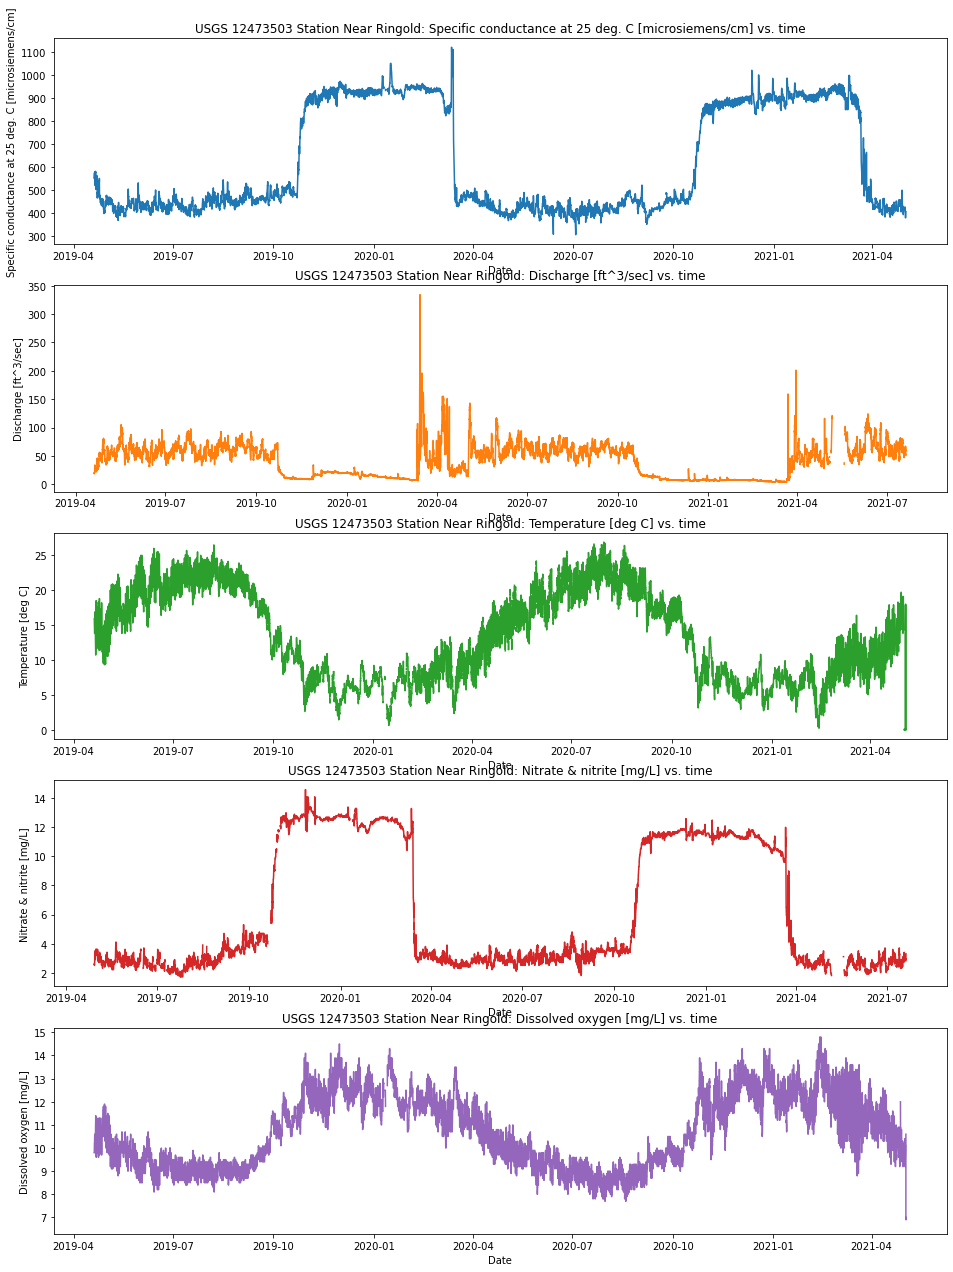

In [60]:
plotiv = ringold_iv_final.plot(subplots = True, legend=False,figsize=(16,22), xlabel='Date', sharex=False, sharey=False)

for subplotIndex in range(len(plotiv)):
    plotiv[subplotIndex].set_ylabel(IV_NAMES_LIST[subplotIndex])
    plotiv[subplotIndex].set_title("USGS 12473503 Station Near Ringold: " + IV_NAMES_LIST[subplotIndex] + " vs. time")

Text(0.5, 1.0, 'Precipitation, in. vs time')

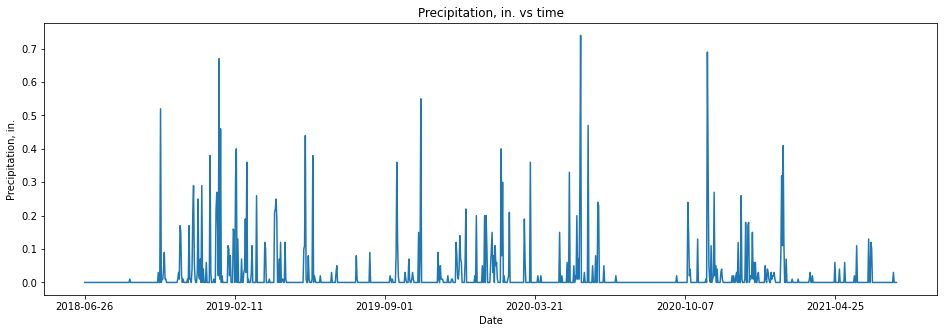

In [19]:
NOAA_DATA = pd.read_csv("noaa_station_data.csv")
NOAA_DATA = NOAA_DATA.set_index('DATE')
precip_plot = NOAA_DATA[["PRCP"]].plot(figsize=(16,5),legend=False)
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Precipitation, in.")
precip_plot.set_title("Precipitation, in. vs time")

In [54]:
kiona_start_date = '2018-06-26'
# kiona_iv = nwis.get_record(sites="12510500",service="iv",parameterCd=final_parameters,start=kiona_start_date,end=endDate)
# kiona_dv = nwis.get_record(sites="12510500",service="dv",parameterCd=final_parameters,start=kiona_start_date,end=endDate)

%store -r kiona_iv
%store -r kiona_dv

Stored 'kiona_iv' (DataFrame)
Stored 'kiona_dv' (DataFrame)


In [56]:
# Copy raw KIONA IV dataset from NWIS
kiona_iv_final = copy.deepcopy(kiona_iv)

# Isolate the target parameters
kiona_iv_final = kiona_iv_final[final_parameters]

# Remove all impossible values by setting the data to its positive values
for column in kiona_iv_final:
    kiona_iv_final = kiona_iv_final[kiona_iv_final[column] > 0]

# Print
display(kiona_iv_final)

# Prepare for plotting - rename values (dictionary already defined in Ringold method)
kiona_iv_final.rename(columns = IV_NAMES, inplace = True)

# Convert datestamp objects to datetime index (Austin's method)
kiona_iv_final.reset_index(inplace = True)
kiona_iv_final['datetime'] = pd.to_datetime(kiona_iv_final['datetime'])
kiona_iv_final.set_index('datetime', inplace = True)

,00095,00060,00010,99133,00300
datetime,,,,,
2018-06-26T16:30:00.000-07:00,264.0,923.0,26.2,0.99,12.4
2018-06-26T16:45:00.000-07:00,264.0,923.0,26.2,1.00,12.4
2018-06-26T17:00:00.000-07:00,264.0,922.0,26.2,0.99,12.3
2018-06-26T17:15:00.000-07:00,264.0,912.0,26.2,0.99,12.2
2018-06-26T17:30:00.000-07:00,264.0,912.0,26.1,0.99,12.2
...,...,...,...,...,...
2020-09-30T23:45:00.000-07:00,246.0,2130.0,16.9,1.20,9.2
2020-10-01T00:00:00.000-07:00,246.0,2130.0,16.8,1.20,9.2
2020-10-01T00:15:00.000-07:00,246.0,2130.0,16.8,1.19,9.1


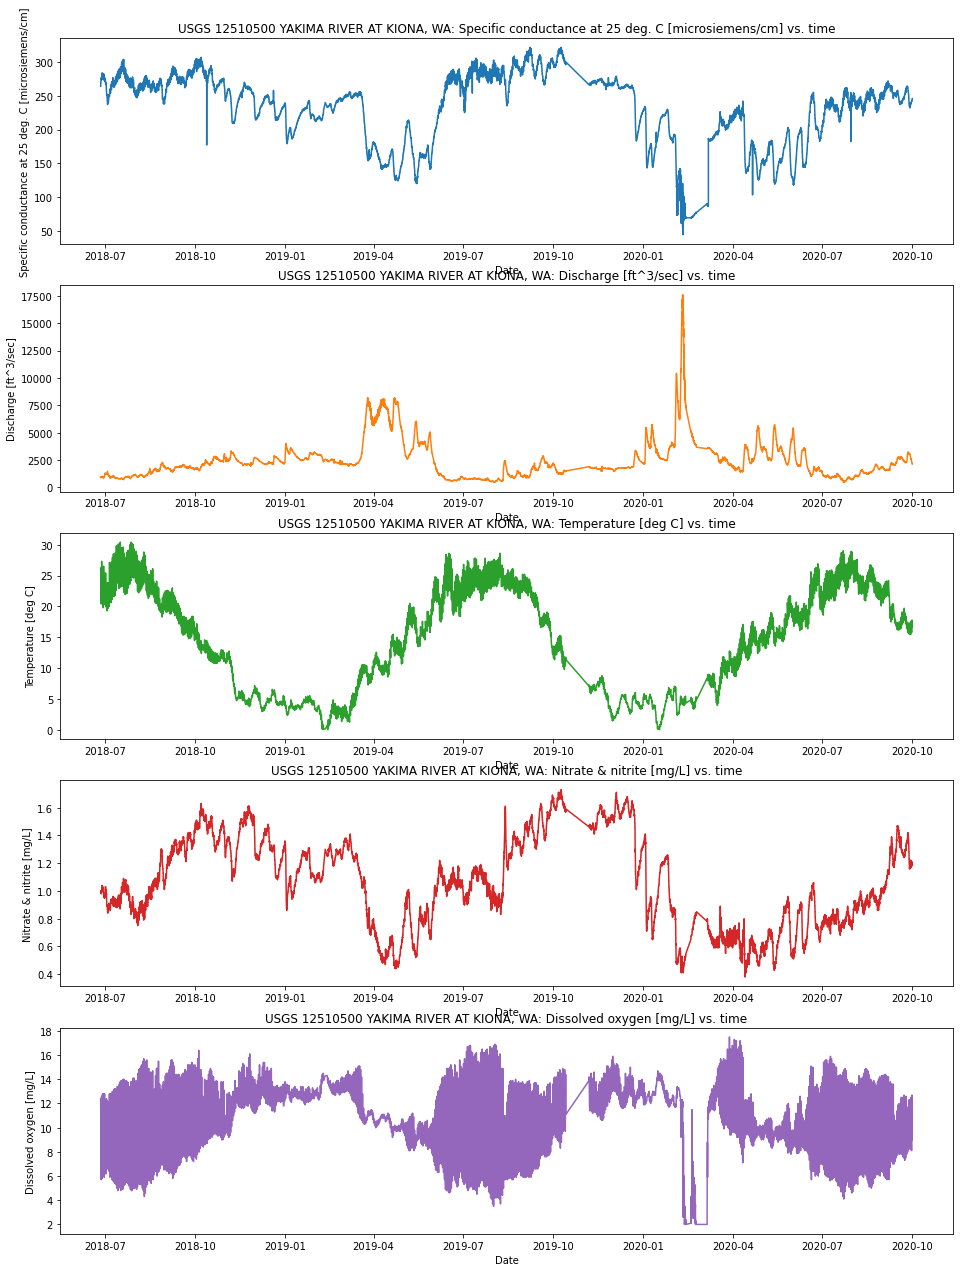

In [57]:
# Graphing
kionaplot = kiona_iv_final.plot(subplots = True, legend=False,figsize=(16,22), xlabel='Date', sharex=False, sharey=False)

for subplotIndex in range(len(kionaplot)):
    kionaplot[subplotIndex].set_ylabel(IV_NAMES_LIST[subplotIndex])
    kionaplot[subplotIndex].set_title("USGS 12510500 YAKIMA RIVER AT KIONA, WA: " + IV_NAMES_LIST[subplotIndex] + " vs. time")

Text(0, 0.5, 'Precipitation, in.')

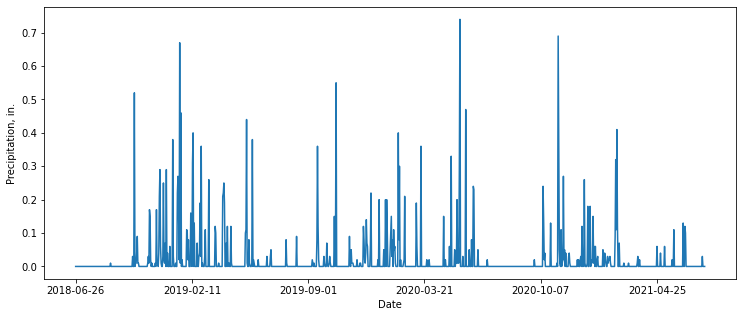

In [41]:
precip_plot = NOAA_DATA[["PRCP"]].plot(figsize=(12.4,5),legend=False)
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Precipitation, in.")

<AxesSubplot:xlabel='Discharge [ft^3/sec]', ylabel='Nitrate & nitrite [mg/L]'>

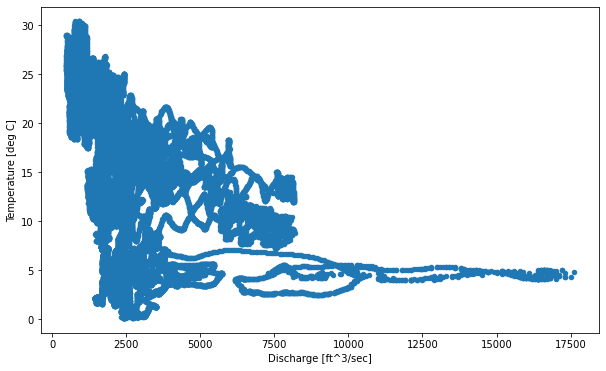

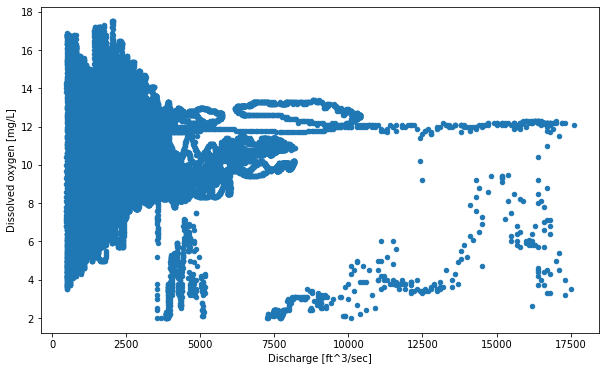

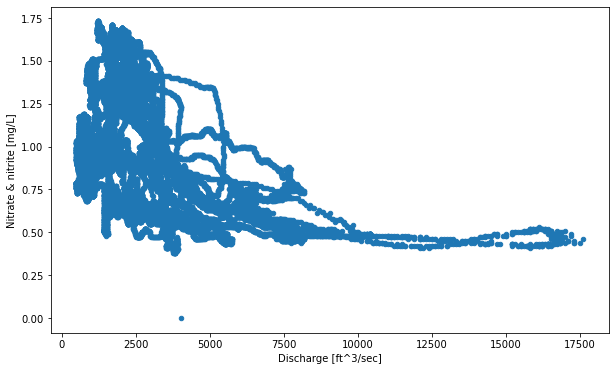

In [67]:
# Discharge [ft^3/sec]	Temperature [deg C]	Dissolved oxygen [mg/L]	Nitrate & nitrite [mg/L]
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Temperature [deg C]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Dissolved oxygen [mg/L]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Nitrate & nitrite [mg/L]",kind='scatter',figsize=(10,6))

In [21]:
nwis.get_info(sites=['12473503','12510500'])[0]

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,12473503,"SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA",ST-DCH,463211.48,1191648.25,46.536522,-119.280069,N,S,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,12510500,"YAKIMA RIVER AT KIONA, WA",ST,461513.00,1192837.00,46.253467,-119.478079,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
m = Map(center=(47,-120), zoom=7)

m.add_layer(Marker(title='SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA',location=(46.536522,-119.280069),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='YAKIMA RIVER AT KIONA, WA',location = (46.253467,-119.478079),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='NOAA STATION - ICE HARBOR DAM',location = (46.2447,-118.8786),rise_on_hover = True, draggable = False))

basemap1 = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(basemap1)

display(m)

Map(center=[47, -120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…